In [1]:
import sys
sys.path.append('../python')

from plotMethods import *
from constants import *
import plotParameters

%matplotlib inline

In [2]:
import pandas as pd
import h5py

filePath_voxels = '/Users/noah-everett/Documents_non-iCloud/dsps/greedyGrids/NEW_voxel_paths_0.parquet'
filePath_true   = '/Users/noah-everett/Documents_non-iCloud/dsps/mldata/trainData_6/0.h5'

df = pd.read_parquet(filePath_voxels)

with h5py.File(filePath_true, 'r') as f:
    # Load the true paths from the HDF5 file
    true = f['y'][:]
true = true[:,:,:]

In [3]:
# print(df.head())
#      file_id  photon_idx  ix  iy  iz    dist_mm
# 0  DF_hits_0           0  79  77   2   3.743350
# 1  DF_hits_0           0  79  77   3   1.644414
# 2  DF_hits_0           0  78  77   3   1.986686
# 3  DF_hits_0           0  78  76   3  29.057095
# 4  DF_hits_0           0  77  76   3  31.043781

df = df.drop(columns=['file_id'])
# print(df.head())
#    photon_idx  ix  iy  iz    dist_mm
# 0           0  79  77   2   3.743350
# 1           0  79  77   3   1.644414
# 2           0  78  77   3   1.986686
# 3           0  78  76   3  29.057095
# 4           0  77  76   3  31.043781

df

,photon_idx,ix,iy,iz,dist_mm
0,0,79,77,2,3.743350
1,0,79,77,3,1.644414
2,0,78,77,3,1.986686
3,0,78,76,3,29.057095
4,0,77,76,3,31.043781
...,...,...,...,...,...
112255793,1240035,79,79,11,31.455073
112255794,1240035,79,79,12,31.455073
112255795,1240035,79,79,13,31.455073
112255796,1240035,79,79,14,31.455073


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

gridSize = true.shape
plotGridSize = (40, 40, 40)

def plot(pred=None, true=None):
    if pred is None:
        pred = np.zeros(gridSize)
    if true is None:
        true = np.zeros(gridSize)

    step = (pred.shape[0]//plotGridSize[0], pred.shape[1]//plotGridSize[1], pred.shape[2]//plotGridSize[2])
    assert (pred.shape[0] % plotGridSize[0] == 0) and (pred.shape[1] % plotGridSize[1] == 0) and (pred.shape[2] % plotGridSize[2] == 0)
    pred = pred.reshape(plotGridSize[0], step[0], plotGridSize[1], step[1], plotGridSize[2], step[2]).mean(axis=(1,3,5))
    true = true.reshape(plotGridSize[0], step[0], plotGridSize[1], step[1], plotGridSize[2], step[2]).mean(axis=(1,3,5))

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    xEdges = np.linspace(-DETECTOR_SIZE_MM[0]/2, DETECTOR_SIZE_MM[0]/2, plotGridSize[0] + 1)
    yEdges = np.linspace(-DETECTOR_SIZE_MM[1]/2, DETECTOR_SIZE_MM[1]/2, plotGridSize[1] + 1)
    zEdges = np.linspace(-DETECTOR_SIZE_MM[2]/2, DETECTOR_SIZE_MM[2]/2, plotGridSize[2] + 1)
    yEdges, xEdges, zEdges = np.meshgrid(xEdges, yEdges, zEdges)

    minVal = np.min(pred[np.nonzero(pred)])
    maxVal = np.max(pred)
    alpha_filled = 0.5
    globalColorNorm = cm.colors.Normalize(vmin=minVal, vmax=maxVal)
    pred = np.where(pred < minVal, 0, pred)
    colors = cm.viridis(globalColorNorm(pred))

    ax = plot_grid(
        ax,
        xEdges,
        yEdges,
        zEdges,
        recoGrid=pred,
        recoGridFaceColors=colors,
        recoGridEdgeColors=np.clip(colors*2-0.5, 0, 1),
        recoGridAlpha=alpha_filled,
        trueGrid=true,
        trueGridEdgeColors='red',
        trueGridAlpha=0,
        nullGridAlpha=0.3,
        linewidth=0.5,
        cbar=True,
        colorNorm=globalColorNorm,
        cmap=cm.viridis,
    )

    ax.set_axis_off()
    ax.set_aspect('equal')

    # plt.savefig(f'{figuresDir}/{fileNumber}_[{predsDir}].pdf', bbox_inches='tight')
    plt.show()

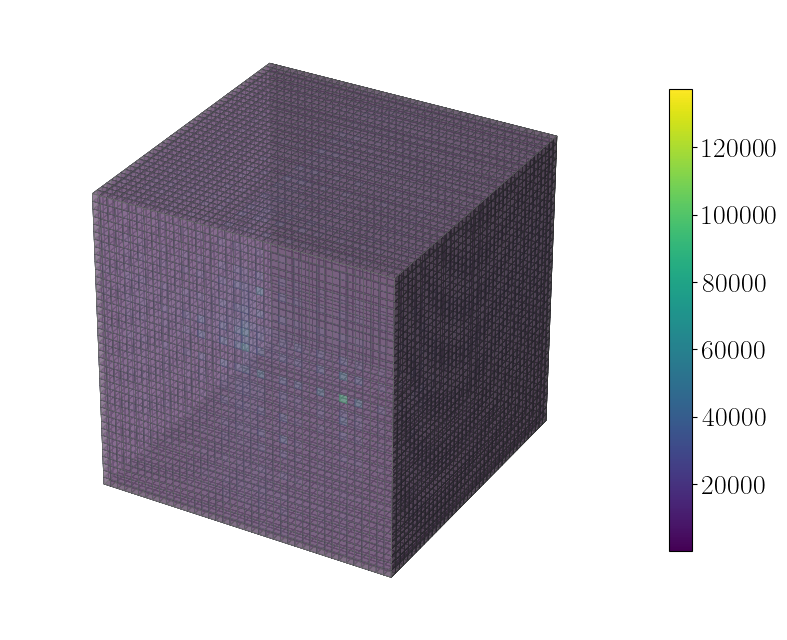

In [5]:
def calculateGrid(df):
    """
    Vectorized replacement for calculateGrid.
    Builds a 3D grid of total distances using a flattened index + bincount.
    """
    ix = df['ix'].to_numpy(dtype=np.int64)
    iy = df['iy'].to_numpy(dtype=np.int64)
    iz = df['iz'].to_numpy(dtype=np.int64)
    w  = df['dist_mm'].to_numpy()

    flat = np.ravel_multi_index((ix, iy, iz), gridSize)
    summed = np.bincount(flat, weights=w, minlength=np.prod(gridSize))
    return summed.reshape(gridSize)

plot(pred=calculateGrid(df))

  0%|          | 0/10 [00:00<?, ?it/s]

Step 1/10: max at (66, 1, 45) with value 561510.4747200244
18328 photons pass through this voxel: [  88882   88883   88884 ... 1226973 1227007 1227024]


 10%|█         | 1/10 [00:11<01:39, 11.05s/it]

110506277 rows remain in the dataframe
Step 2/10: max at (66, 2, 50) with value 270630.64137793926
8892 photons pass through this voxel: [ 105445  105446  105447 ... 1234712 1234713 1234714]


 20%|██        | 2/10 [00:19<01:15,  9.49s/it]

109654682 rows remain in the dataframe
Step 3/10: max at (71, 1, 45) with value 233232.4765978856
7660 photons pass through this voxel: [  88695   88696   88697 ... 1227325 1234254 1234872]


 30%|███       | 3/10 [00:27<01:01,  8.83s/it]

109005403 rows remain in the dataframe
Step 4/10: max at (45, 1, 66) with value 228904.0319261945
7500 photons pass through this voxel: [ 134594  134595  134648 ... 1200250 1200251 1200252]


 40%|████      | 4/10 [00:36<00:52,  8.72s/it]

108295295 rows remain in the dataframe
Step 5/10: max at (61, 1, 45) with value 206465.7914598152
7232 photons pass through this voxel: [  88968   88984   89004 ... 1217271 1217272 1218259]


 50%|█████     | 5/10 [00:44<00:42,  8.48s/it]

107598356 rows remain in the dataframe
Step 6/10: max at (45, 1, 45) with value 201158.20288136083
6630 photons pass through this voxel: [  70280   70281   70282 ... 1183163 1183164 1183211]


 60%|██████    | 6/10 [00:51<00:33,  8.27s/it]

106970468 rows remain in the dataframe
Step 7/10: max at (40, 1, 50) with value 181765.47689504857
6038 photons pass through this voxel: [  86349   86350   86351 ... 1184597 1184598 1184599]


 70%|███████   | 7/10 [00:59<00:24,  8.16s/it]

106402356 rows remain in the dataframe
Step 8/10: max at (66, 2, 39) with value 181525.6886736526
5942 photons pass through this voxel: [  72733   72734   72735 ... 1226972 1226973 1226974]


 80%|████████  | 8/10 [01:07<00:15,  7.88s/it]

105836660 rows remain in the dataframe
Step 9/10: max at (50, 1, 29) with value 158423.9841107853
5189 photons pass through this voxel: [  34653   34654   34655 ... 1196949 1196983 1196984]


 90%|█████████ | 9/10 [01:14<00:07,  7.73s/it]

105339212 rows remain in the dataframe
Step 10/10: max at (40, 1, 55) with value 157580.05915144394
5738 photons pass through this voxel: [ 102687  102688  102689 ... 1184678 1184679 1184719]


100%|██████████| 10/10 [01:22<00:00,  8.23s/it]

104811952 rows remain in the dataframe


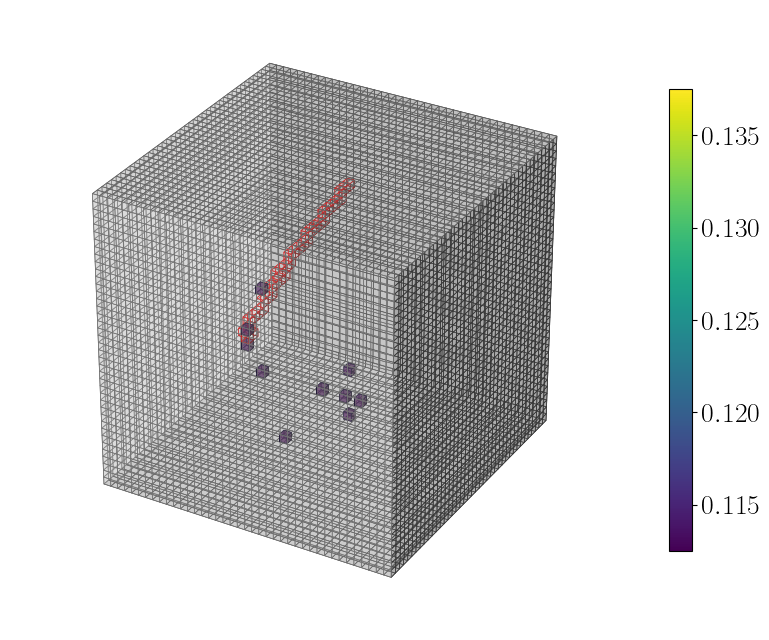

In [ ]:
from tqdm import tqdm

steps = 10
pred_rmAll = np.zeros(gridSize)
df_rmAll = df.copy()
for step in tqdm(range(steps)):
    # calculate the current grid
    grid = calculateGrid(df_rmAll)

    # find the voxel with the most total distance
    maxInd = np.unravel_index(np.argmax(grid, axis=None), grid.shape)
    print(f'Step {step+1}/{steps}: max at {maxInd} with value {grid[maxInd]}')

    # add this voxel to the prediction
    pred_rmAll[maxInd] += 1

    # find all photons that pass through this voxel
    photonIds = df[(df['ix'] == maxInd[0]) & (df['iy'] == maxInd[1]) & (df['iz'] == maxInd[2])]['photon_idx'].unique()
    print(f'{len(photonIds)} photons pass through this voxel: {photonIds}')

    # remove all these photons from the dataframe
    df_rmAll = df_rmAll[~df_rmAll['photon_idx'].isin(photonIds)]
    print(f'{len(df_rmAll)} rows remain in the dataframe')

plot(pred=pred_rmAll, true=true)

  0%|          | 0/10 [00:00<?, ?it/s]

Step 1/10: max at (66, 1, 45) with value 561510.4747200244


 10%|█         | 1/10 [00:21<03:17, 21.95s/it]

18328 photons pass through this voxel: [  88882   88883   88884 ... 1226973 1227007 1227024]
112254610 rows remain in the dataframe (removed 1188)
Step 2/10: max at (66, 1, 45) with value 554313.1799835302


 20%|██        | 2/10 [00:39<02:35, 19.43s/it]

18328 photons pass through this voxel: [  88882   88883   88884 ... 1226973 1227007 1227024]
112254610 rows remain in the dataframe (removed 0)
Step 3/10: max at (66, 1, 45) with value 547209.4375804996


 30%|███       | 3/10 [00:57<02:11, 18.83s/it]

18328 photons pass through this voxel: [  88882   88883   88884 ... 1226973 1227007 1227024]
112254610 rows remain in the dataframe (removed 0)
Step 4/10: max at (66, 1, 45) with value 540197.9816837914


 40%|████      | 4/10 [01:15<01:50, 18.50s/it]

18328 photons pass through this voxel: [  88882   88883   88884 ... 1226973 1227007 1227024]
112254610 rows remain in the dataframe (removed 0)
Step 5/10: max at (66, 1, 45) with value 533277.5656153973


 50%|█████     | 5/10 [01:33<01:31, 18.37s/it]

18328 photons pass through this voxel: [  88882   88883   88884 ... 1226973 1227007 1227024]
112254610 rows remain in the dataframe (removed 0)
Step 6/10: max at (66, 1, 45) with value 526446.9614766104


 60%|██████    | 6/10 [01:51<01:12, 18.15s/it]

18328 photons pass through this voxel: [  88882   88883   88884 ... 1226973 1227007 1227024]
112254610 rows remain in the dataframe (removed 0)
Step 7/10: max at (66, 1, 45) with value 519704.9597865015


 70%|███████   | 7/10 [02:10<00:54, 18.26s/it]

18328 photons pass through this voxel: [  88882   88883   88884 ... 1226973 1227007 1227024]
112254610 rows remain in the dataframe (removed 0)
Step 8/10: max at (66, 1, 45) with value 513050.36913037073


 80%|████████  | 8/10 [02:30<00:37, 18.85s/it]

18328 photons pass through this voxel: [  88882   88883   88884 ... 1226973 1227007 1227024]
112254610 rows remain in the dataframe (removed 0)
Step 9/10: max at (66, 1, 45) with value 506482.015817842


 90%|█████████ | 9/10 [02:50<00:19, 19.36s/it]

18328 photons pass through this voxel: [  88882   88883   88884 ... 1226973 1227007 1227024]
112254600 rows remain in the dataframe (removed 10)
Step 10/10: max at (66, 1, 45) with value 499998.7435499397


100%|██████████| 10/10 [03:09<00:00, 18.99s/it]

18328 photons pass through this voxel: [  88882   88883   88884 ... 1226973 1227007 1227024]
112254600 rows remain in the dataframe (removed 0)


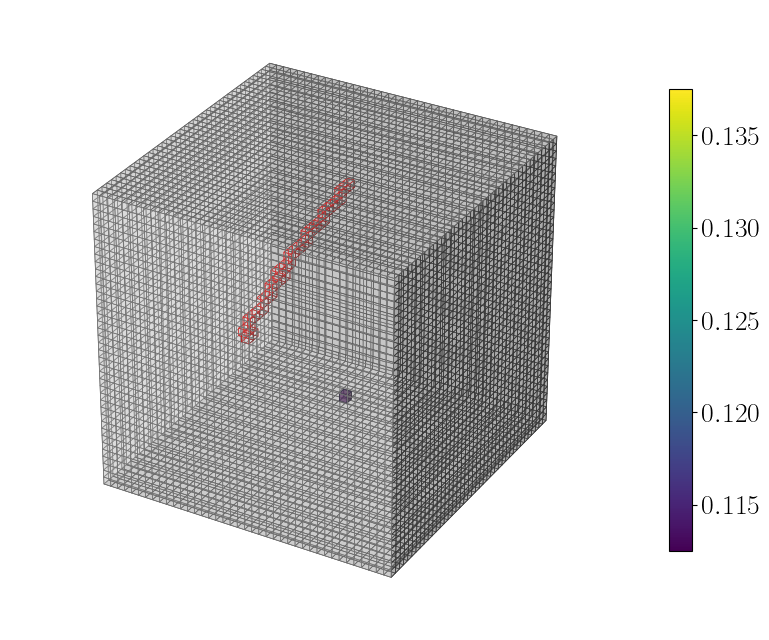

In [ ]:
from tqdm import tqdm

steps = 10
pred_rmProp = np.zeros(gridSize, dtype=np.uint8)
df_rmProp = df.copy()
maxInd = None
for step in tqdm(range(steps)):
    # 1) compute current grid (fast)
    grid = calculateGrid(df_rmProp)

    # 2) pick argmax voxel
    max_flat = np.argmax(grid, axis=None)
    maxInd = np.unravel_index(max_flat, grid.shape)
    print(f"Step {step+1}/{steps}: max at {maxInd} with value {grid[maxInd]}")

    # mark prediction voxel
    pred_rmProp[maxInd] += 1

    # 3) photons that traverse this voxel (vectorized)
    vx, vy, vz = maxInd
    mask_voxel = (df_rmProp['ix'] == vx) & (df_rmProp['iy'] == vy) & (df_rmProp['iz'] == vz)

    # If no rows, skip updates quickly
    if not mask_voxel.any():
        print("0 photons pass through this voxel.")
        print(f"{len(df_rmProp)} rows remain in the dataframe")
        continue

    # (a) distance IN the selected voxel per photon
    dist_in_voxel_by_photon = (
        df_rmProp.loc[mask_voxel, ['photon_idx', 'dist_mm']]
        .groupby('photon_idx', sort=False)['dist_mm']
        .sum()
    )

    # (b) total distance per photon (across all voxels)
    total_by_photon = (
        df_rmProp.groupby('photon_idx', sort=False)['dist_mm']
        .sum()
    )

    # (c) proportion to remove per photon = dist_in_voxel / total
    #     map only for photons that touched the voxel
    touched_photons = dist_in_voxel_by_photon.index
    props = (dist_in_voxel_by_photon / total_by_photon.loc[touched_photons]).clip(0.0, 1.0)

    # 4) apply scaling factor (1 - prop) to ALL rows for these photons via a join
    factors = (1.0 - props).rename('factor')
    df_rmProp = df_rmProp.merge(factors, left_on='photon_idx', right_index=True, how='left')
    # photons not touched by the voxel keep factor=1
    df_rmProp['factor'] = df_rmProp['factor'].fillna(1.0)

    # scale distances in place
    df_rmProp['dist_mm'] = df_rmProp['dist_mm'] * df_rmProp['factor']

    # drop helper column
    df_rmProp.drop(columns='factor', inplace=True)

    # 5) prune tiny distances in one shot
    before = len(df_rmProp)
    df_rmProp = df_rmProp[df_rmProp['dist_mm'] >= 1e-3].reset_index(drop=True)
    after = len(df_rmProp)

    print(f"{len(touched_photons)} photons pass through this voxel: {touched_photons.to_numpy()}")
    print(f"{after} rows remain in the dataframe (removed {before - after})")

# plot results
plot(pred=pred_rmProp, true=true)